In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import json

In [2]:
from verificators import ActiveVerificator, AgglomerativeVerificator, MeanShiftVerificator, AffinityVerificator, DBSCANVerificator
from tester import ClusteringTester

In [3]:
with open('data/embeddings_labeled.pkl', 'rb') as f:
	embeddings, labels = tuple(map(np.array, pickle.load(f)))

In [13]:
def test_all(**kwargs):
    results = {}
    
    verificator = ActiveVerificator()
    tester = ClusteringTester(verificator, embeddings, labels)
    results['active'] = tester.test(**kwargs, use_tqdm=True)
    
    results['agg_cos'] = []
    for threshold in tqdm(np.arange(0.5, 0.99, 0.02)):
        verificator = AgglomerativeVerificator(threshold, 'cosine', 'average')
        tester = ClusteringTester(verificator, embeddings, labels)
        result = tester.test(**kwargs, n_tests=500)
        result['param'] = threshold
        results['agg_cos'].append(result)
        
    results['agg_ward'] = []
    for threshold in tqdm(np.arange(50, 90, 2)):
        verificator = AgglomerativeVerificator(threshold, 'euclidean', 'ward')
        tester = ClusteringTester(verificator, embeddings, labels)
        result = tester.test(**kwargs, n_tests=500)
        result['param'] = threshold
        results['agg_ward'].append(result)
        
    results['meanshift'] = []
    for threshold in tqdm(np.arange(30, 60, 2)):
        verificator = MeanShiftVerificator(threshold)
        tester = ClusteringTester(verificator, embeddings, labels)
        result = tester.test(**kwargs, n_tests=500)
        result['param'] = threshold
        results['meanshift'].append(result)

    results['dbscan'] = []
    for threshold in tqdm(np.arange(0.5, 0.99, 0.02)):
        verificator = DBSCANVerificator(threshold)
        tester = ClusteringTester(verificator, embeddings, labels)
        result = tester.test(**kwargs, n_tests=500)
        result['param'] = threshold
        results['dbscan'].append(result)
        
    verificator = AffinityVerificator('cosine')
    tester = ClusteringTester(verificator, embeddings, labels)
    results['aff'] = tester.test(**kwargs, use_tqdm=True)
    
    # verificator = AffinityVerificator('euclidean')
    # tester = ClusteringTester(verificator, embeddings, labels)
    # results['aff_euc'] = tester.test(**kwargs, use_tqdm=True)
    
    return results

In [14]:
results_5_5 = test_all()

100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


In [15]:
results_5_20 = test_all(n_users_type1=5, n_utts_per_user_type1=20)
results_10_3 = test_all(n_users_type1=10, n_utts_per_user_type1=3)
results_5_20_5_3 = test_all(n_users_type1=5, n_utts_per_user_type1=20, n_users_type2=5, n_utts_per_user_type2=3)

100%|██████████| 20/20 [04:14<00:00, 12.73s/it]


In [16]:
x_ward = np.arange(50, 90, 2)
x_cos = np.arange(0.5, 0.99, 0.02)
acc_5_5_ward, vm_5_5_ward, eer_5_5_ward = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_5['agg_ward']])
acc_5_20_ward, vm_5_20_ward, eer_5_20_ward = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_20['agg_ward']])
acc_10_3_ward, vm_10_3_ward, eer_10_3_ward = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_10_3['agg_ward']])
acc_mix_ward, vm_mix_ward, eer_mix_ward = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_20_5_3['agg_ward']])
acc_5_5_cos, vm_5_5_cos, eer_5_5_cos = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_5['agg_cos']])
acc_5_20_cos, vm_5_20_cos, eer_5_20_cos = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_20['agg_cos']])
acc_10_3_cos, vm_10_3_cos, eer_10_3_cos = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_10_3['agg_cos']])
acc_mix_cos, vm_mix_cos, eer_mix_cos = zip(*[[res['clustering_acc'], res['v_measure_total'], res['guest_detection_eer']] for res in results_5_20_5_3['agg_cos']])

In [29]:
results_5_5['active']

{'clustering_acc': 1.0,
 'v_measure_total': 0.9901818644426581,
 'v_measure_correct': 0.9901818644426581,
 'guest_detection_eer': 0.019584000000007262}

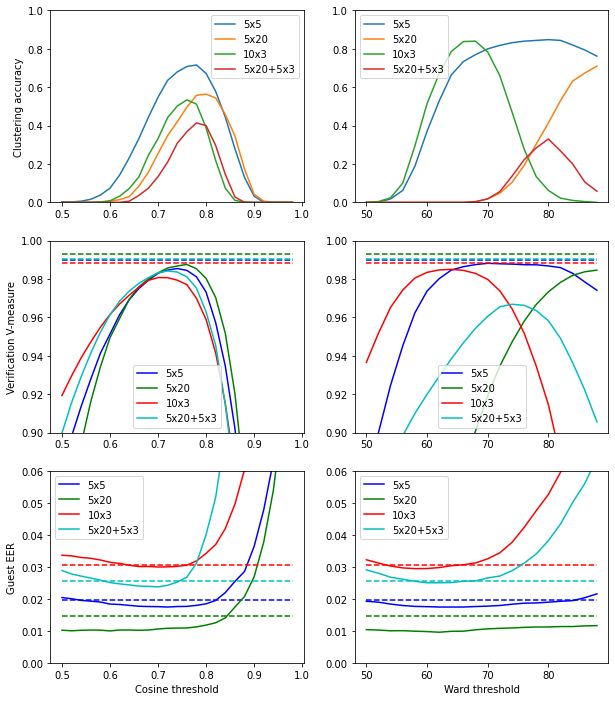

In [44]:
plt.figure(figsize=(10, 12))
plt.subplot(3, 2, 4)
plt.plot(x_ward, vm_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['v_measure_total']] * len(x_ward), 'b--')
plt.plot(x_ward, vm_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['v_measure_total']] * len(x_ward), 'g--')
plt.plot(x_ward, vm_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['v_measure_total']] * len(x_ward), 'r--')
plt.plot(x_ward, vm_mix_ward, 'c', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['v_measure_total']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)
plt.subplot(3, 2, 3)
plt.plot(x_cos, vm_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['v_measure_total']] * len(x_cos), 'b--')
plt.plot(x_cos, vm_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['v_measure_total']] * len(x_cos), 'g--')
plt.plot(x_cos, vm_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['v_measure_total']] * len(x_cos), 'r--')
plt.plot(x_cos, vm_mix_cos, 'c', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['v_measure_total']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.9, 1.0)
plt.ylabel('Verification V-measure')
plt.subplot(3, 2, 2)
plt.plot(x_ward, acc_5_5_ward, label='5x5')
plt.plot(x_ward, acc_5_20_ward, label='5x20')
plt.plot(x_ward, acc_10_3_ward, label='10x3')
plt.plot(x_ward, acc_mix_ward, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)
plt.subplot(3, 2, 1)
plt.plot(x_cos, acc_5_5_cos, label='5x5')
plt.plot(x_cos, acc_5_20_cos, label='5x20')
plt.plot(x_cos, acc_10_3_cos, label='10x3')
plt.plot(x_cos, acc_mix_cos, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)
plt.ylabel('Clustering accuracy')
plt.subplot(3, 2, 6)
plt.plot(x_ward, eer_5_5_ward, 'b', label='5x5')
plt.plot(x_ward, [results_5_5['active']['guest_detection_eer']] * len(x_ward), 'b--')
plt.plot(x_ward, eer_5_20_ward, 'g', label='5x20')
plt.plot(x_ward, [results_5_20['active']['guest_detection_eer']] * len(x_ward), 'g--')
plt.plot(x_ward, eer_10_3_ward, 'r', label='10x3')
plt.plot(x_ward, [results_10_3['active']['guest_detection_eer']] * len(x_ward), 'r--')
plt.plot(x_ward, eer_mix_ward, 'c', label='5x20+5x3')
plt.plot(x_ward, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_ward), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Ward threshold')
plt.subplot(3, 2, 5)
plt.plot(x_cos, eer_5_5_cos, 'b', label='5x5')
plt.plot(x_cos, [results_5_5['active']['guest_detection_eer']] * len(x_cos), 'b--')
plt.plot(x_cos, eer_5_20_cos, 'g', label='5x20')
plt.plot(x_cos, [results_5_20['active']['guest_detection_eer']] * len(x_cos), 'g--')
plt.plot(x_cos, eer_10_3_cos, 'r', label='10x3')
plt.plot(x_cos, [results_10_3['active']['guest_detection_eer']] * len(x_cos), 'r--')
plt.plot(x_cos, eer_mix_cos, 'c', label='5x20+5x3')
plt.plot(x_cos, [results_5_20_5_3['active']['guest_detection_eer']] * len(x_cos), 'c--')
plt.legend()
plt.ylim(0.0, 0.06)
plt.xlabel('Cosine threshold')
plt.ylabel('Guest EER')
plt.show()

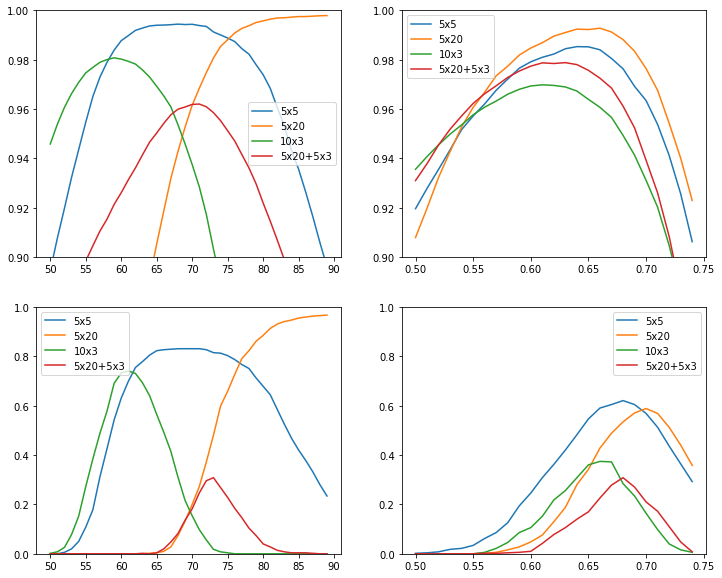

In [14]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(x_ward, vm_5_5_ward, label='5x5')
plt.plot(x_ward, vm_5_20_ward, label='5x20')
plt.plot(x_ward, vm_10_3_ward, label='10x3')
plt.plot(x_ward, vm_mix_ward, label='5x20+5x3')
plt.legend()
plt.ylim(0.9, 1.0)
plt.subplot(2, 2, 2)
plt.plot(x_cos, vm_5_5_cos, label='5x5')
plt.plot(x_cos, vm_5_20_cos, label='5x20')
plt.plot(x_cos, vm_10_3_cos, label='10x3')
plt.plot(x_cos, vm_mix_cos, label='5x20+5x3')
plt.legend()
plt.ylim(0.9, 1.0)
plt.subplot(2, 2, 3)
plt.plot(x_ward, acc_5_5_ward, label='5x5')
plt.plot(x_ward, acc_5_20_ward, label='5x20')
plt.plot(x_ward, acc_10_3_ward, label='10x3')
plt.plot(x_ward, acc_mix_ward, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)
plt.subplot(2, 2, 4)
plt.plot(x_cos, acc_5_5_cos, label='5x5')
plt.plot(x_cos, acc_5_20_cos, label='5x20')
plt.plot(x_cos, acc_10_3_cos, label='10x3')
plt.plot(x_cos, acc_mix_cos, label='5x20+5x3')
plt.legend()
plt.ylim(0.0, 1.0)
plt.show()

In [37]:
eer = np.array(json.load(open('data/eer_results.json')))

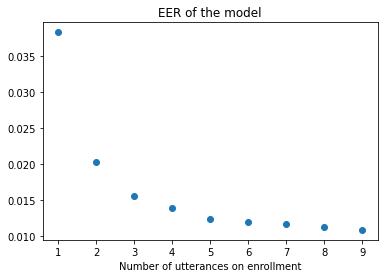

In [39]:
plt.scatter(eer[:, 0], eer[:, 1])
plt.title('EER of the model')
plt.xlabel('Number of utterances on enrollment')
plt.show()

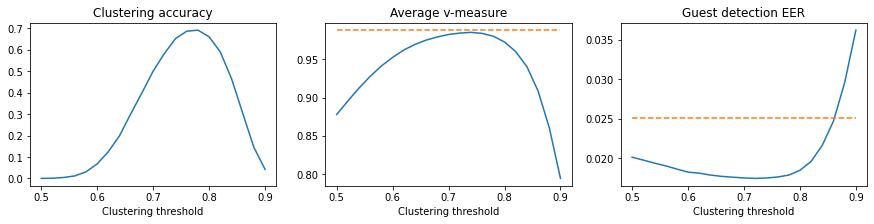

In [19]:
accs, vms, vmcs, geers, ths = zip(*[list(result.values()) for result in cos_avg_results])

plt.figure(figsize=(15, 3))

plt.subplot(1, 3, 1)
plt.title('Clustering accuracy')
plt.xlabel('Clustering threshold')
plt.plot(ths, accs)

plt.subplot(1, 3, 2)
plt.title('Average v-measure')
plt.xlabel('Clustering threshold')
plt.plot(ths, vms)
plt.plot(ths, [active_results['v_measure_total']] * len(ths), '--')

plt.subplot(1, 3, 3)
plt.title('Guest detection EER')
plt.xlabel('Clustering threshold')
plt.plot(ths, geers)
plt.plot(ths, [active_results['guest_detection_eer']] * len(ths), '--')

plt.show()